# Банки — Сегментация пользователей по потреблению

Исследование клиентов регионального банка «Метанпром» проводилось на реальном срезе данных клиентов из этого банка.

Цель исследования: снизить отток клиентов банка.

Задачи исследования:
1. Сегментировать пользователей по количеству потребляемых банковских продуктов, обращая особое внимание на отток.
2. Выдвинуть релевантные предложения каждому сегменту. 


Описание проекта:
1. Загрузка необходимых библиотек и первичное знакомство с данными
- изучаем датафрейм, из каких столбцов он состоит и какую информацию содержит
- изучаем цифры в датафрейме

2. Предобработка данных
- оцениваем наличие явных и неявных дубликатов, пропусков, выбросов
- прицельное исследование клиентов с пропусками в столбце с балансом, выявление закономерностей
- избавление от дубликатов

3. Исследовательский анализ данных
- графики распределения признаков, построение матрицы корреляций, выявление закономерностей (оценка влияния различных признаков на отток пользователей)
- предварительные выводы 

4. Сегментация клиентов по числу иследуемых продуктов
- выделение нескольких сегментов пользователей по различным признакам, акцентируясь на количестве используемых продуктов и оттоке
- предварительные выводы

5. Проверка гипотез
- статистическая гипотеза о различие возраста между клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним
- статистическая гипотеза о равенстве долей (уровень оттока среди мужчин и женщин)

6. Выводы и рекомендации по удержанию продуктовых сегментов.

# Знакомство с данными

In [44]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px 
import folium
from scipy import stats as st
import math as mth
from statsmodels.stats.proportion import proportions_ztest
sns.set_palette('coolwarm')

In [45]:
!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [46]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
df2 = pd.read_csv(path)

In [47]:
# Создаю функцию для описания данных
def description(x):
    print('\033[1m' + 'Получение общей информации о данных в таблице:' + '\033[0m')
    display(x.info())
    print('\033[1m' + 'Наличие дубликатов в таблице:' + '\033[0m')
    display(x.duplicated().sum())   

In [48]:
description(df2)

Получение общей информации о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


None

Наличие дубликатов в таблице:


0

In [49]:
# оцениваю долю пропусков в столбцах
pd.DataFrame(round(df2.isna().mean()*100,1))

,0
USERID,0.0
score,0.0
city,0.0
gender,0.0
age,0.3
equity,0.0
balance,23.0
products,0.0
credit_card,0.0
last_activity,0.0


В данных присутсвуют пропущенные значения в столбцах с возрастом(3%) и балансом (23%). 

In [50]:
df2.describe(include='all')

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,10000,10000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
unique,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ярославль,М,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,5888,5005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,171814.71260,848.699400,NaN,NaN,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,NaN,NaN,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,NaN,NaN,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,NaN,NaN,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,NaN,NaN,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,NaN,NaN,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000


- В столбце score присутсвуют значения от 642 до 1000, медианное значение баллов скоринга 853.
- В столбце с возрастом от 18 до 86, медианное значение 40 лет.
- В столбце equity (количество баллов собственности) от 0 до 9, медианное значение 3.
- В столбце с продуктами банка от 0 до 5. 
- Столбцы credit_card, last_activity, churn содержат бинарные значения (0, 1).
- В столбцах с расчитанной зп и балансом содержатся достаточно большие значения (необходимо узнать, в каких единицах измерения они находятся). 

# Предобработка даных 

In [51]:
# Привожу названия столбцов к нижнему регистру
df2.columns = df2.columns.str.lower()

## Выявление дубликатов

In [52]:
# Определяю количество дублей в столбце userid
df2.duplicated(subset='userid').sum()

73

In [53]:
# Оцениваю строки с дублями в столбце userid
pd.concat(g for _, g in df2.groupby("userid") if len(g) > 1).head(20)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0


Видно, что остальная информация у дублированных id различна, принимаю решение обновить id клиентов, чтобы не потерять информацию. 

In [54]:
# заменю столбец userid на новый, чтобы избавиться от дублированных id
df2 = df2.drop_duplicates().reset_index()
df2 = df2.drop(labels='userid', axis=1).rename(columns={'index':'userid'})
df2

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,0,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,1,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,2,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,3,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,4,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,9996,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,9997,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,9998,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


Добавила столбец index с уникальными значениями для каждого клиента в датафрейме. 

In [55]:
# проверяю дубли в категориальных переменных
df2['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

В категориальных переменных с названием городов неявных дублей нет, все города написаны правильно. 

# Исследование пропусков

Существуют следующие виду пропусков:
- MCAR (Missing Completely At Random) — механизм формирования пропусков, при котором вероятность пропуска для каждой записи набора одинакова, то есть пропуски не зависят от переменных. В таком случае игнорирование/исключение записей, содержащих пропущенные данные, не ведет к искажению результатов.
- MAR (Missing At Random) — на практике данные обычно пропущены не случайно, а ввиду некоторых закономерностей. Пропуски относят к MAR, если вероятность пропуска может быть определена на основе другой имеющейся в наборе данных информации (пол, возраст, занимаемая должность, образование и тд), не содержащей пропуски. В таком случае удаление или замена пропусков на значение «Пропуск», как и в случае MCAR, не приведет к существенному искажению результатов.
- MNAR (Missing Not At Random) — механизм формирования пропусков, при котором данные отсутствуют в зависимости от неизвестных факторов. MNAR предполагает, что вероятность пропуска могла бы быть описана на основе других атрибутов, но информация по этим атрибутам в наборе данных отсутствует. Как следствие, вероятность пропуска невозможно выразить на основе информации, содержащейся в наборе данных.

Для определения типа пропусков необходимо разделить датасет на 2 группы: без пропущенных значений в балансе и с наличием пропусков и сравнить их по различным признакам. 

In [56]:
df_nan = df2.loc[df2['balance'].isna()] # фильтруем строки, в которых пропущен баланс
df_nan.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,2,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,9,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,10,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,11,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,19,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0


In [57]:
df_balance = df2[~df2['balance'].isna()]  # фильтруем строки без пропусков в балансе
df_balance.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,0,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,1,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
3,3,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,4,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,5,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0


## Распределение по полу

In [58]:
gender = df_balance['gender'].value_counts()
gender

gender
Ж    3982
М    3723
Name: count, dtype: int64

In [59]:
gender_nan = df_nan['gender'].value_counts()
gender_nan

gender
М    1282
Ж    1013
Name: count, dtype: int64

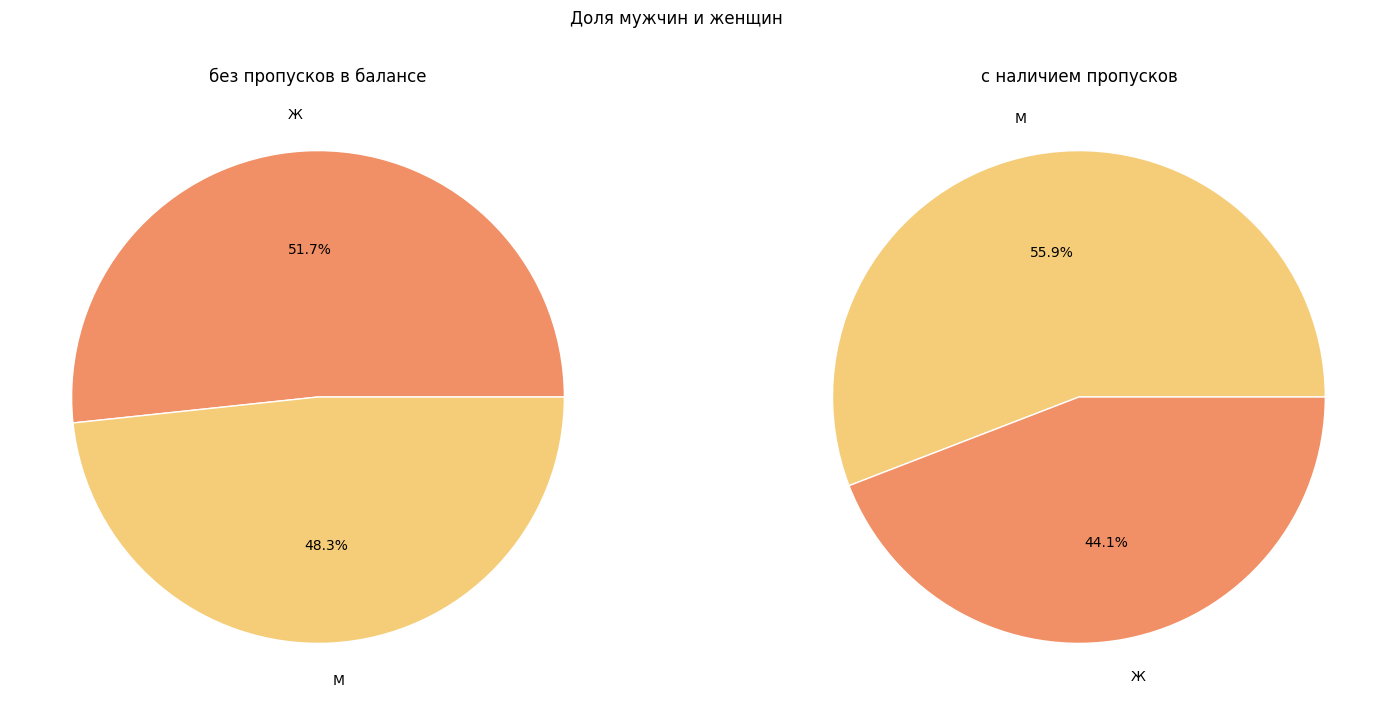

In [60]:
# строю 2 графика           
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8)) 
ax1.pie(gender, labels=gender.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=['#f19066', '#f5cd79'])

ax2.pie(gender_nan, labels=gender_nan.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=['#f5cd79', '#f19066'])

plt.suptitle('Доля мужчин и женщин')
ax1.set_title('без пропусков в балансе') # зададим название графика
ax2.set_title('с наличием пропусков'); # зададим название графика

Доли мужчин и женщин в датафрейме равномерные, пропуски от пола не зависят.

## Распределение по городам

In [61]:
city = df_balance['city'].value_counts()
city

city
Ярославль    4421
Рыбинск      2102
Ростов       1182
Name: count, dtype: int64

In [62]:
city_nan = df_nan['city'].value_counts()
city_nan

city
Ярославль    1467
Рыбинск       593
Ростов        235
Name: count, dtype: int64

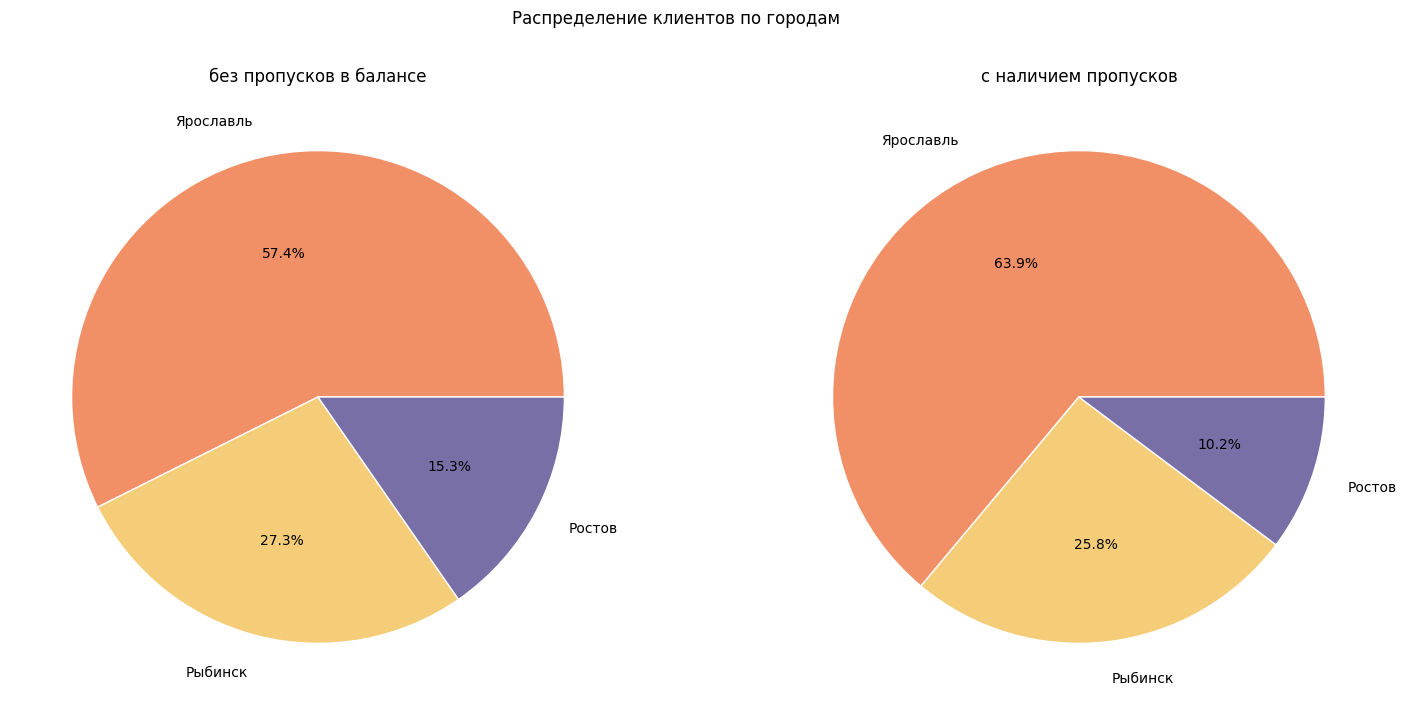

In [63]:
# строю 2 графика           
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8)) 
ax1.pie(city, labels=city.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=['#f19066', '#f5cd79', '#786fa6'])

ax2.pie(city_nan, labels=city_nan.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=['#f19066', '#f5cd79', '#786fa6'])

plt.suptitle('Распределение клиентов по городам')
ax1.set_title('без пропусков в балансе') # зададим название графика
ax2.set_title('с наличием пропусков'); # зададим название графика

Клиентов из Ярославля больше, чем клиентов из Рыбинска и Ростова вместе взятых. Распределение по городам схожее среди клиентов с наличием пропущенных значений и без пропусков. 

In [64]:
churn = df2['churn'].value_counts()
churn

churn
0    8180
1    1820
Name: count, dtype: int64

In [65]:
churn_nan = df_nan['churn'].value_counts()
churn_nan

churn
0    2282
1      13
Name: count, dtype: int64

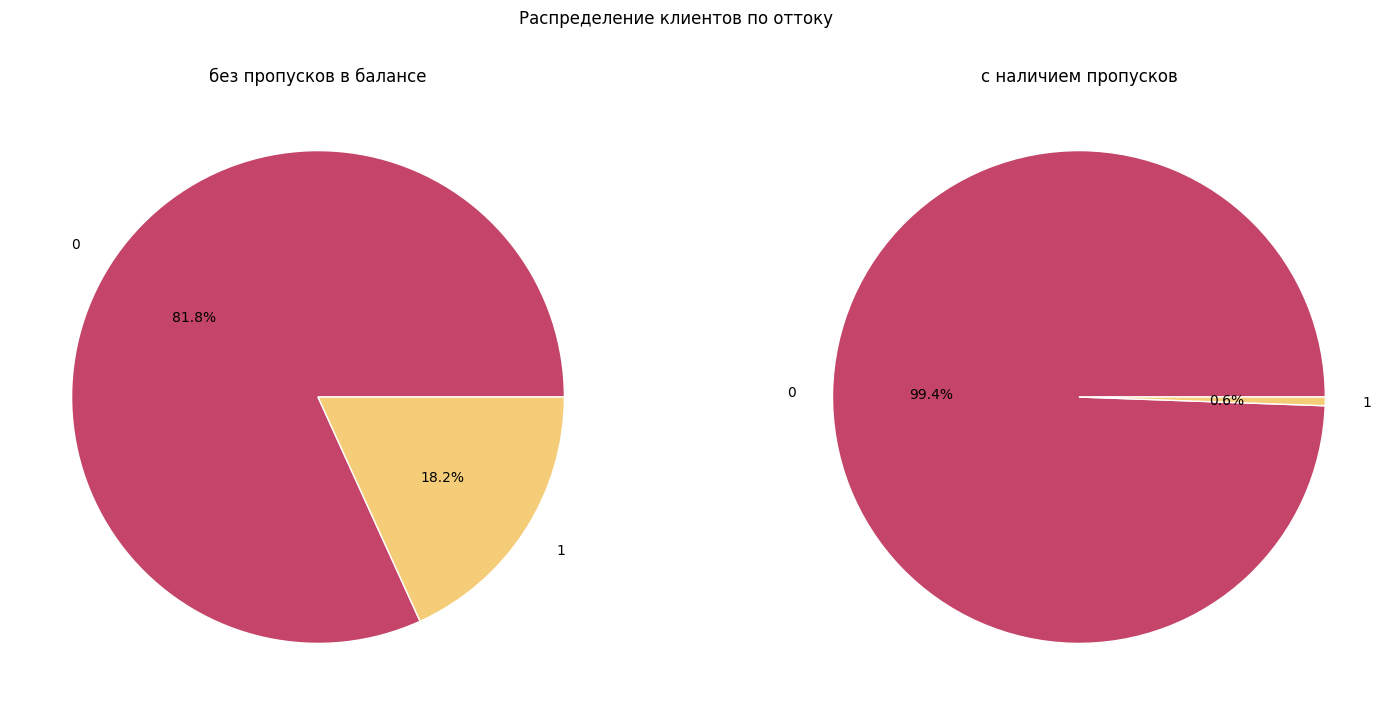

In [66]:
# строю 2 графика           
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8)) 
ax1.pie(churn, labels=churn.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=['#c44569', '#f5cd79', '#786fa6'])

ax2.pie(churn_nan, labels=churn_nan.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=['#c44569', '#f5cd79', '#786fa6'])

plt.suptitle('Распределение клиентов по оттоку')
ax1.set_title('без пропусков в балансе') # зададим название графика
ax2.set_title('с наличием пропусков'); # зададим название графика

Среди клиентов с наличием пропусков практически все являются не отточными. 

## Распределение по возрасту

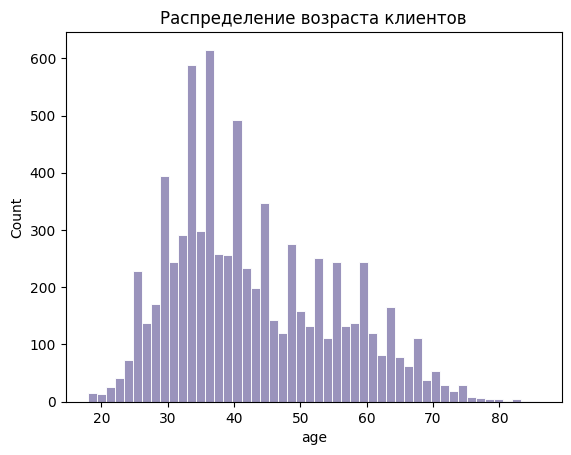

In [67]:
plt.title('Распределение возраста клиентов')
sns.histplot(x=df_balance['age'], bins=50, color = '#786fa6', edgecolor='white');

Распределение по возрасту клиентов близко к нормальному, больше клиентов в возрасте от 30 до 40 лет.

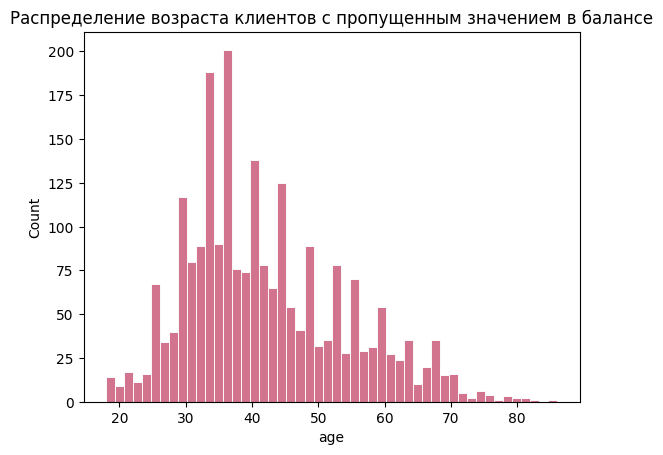

In [68]:
plt.title('Распределение возраста клиентов с пропущенным значением в балансе')
sns.histplot(data=df_nan, x='age', bins=50, color = '#c44569', edgecolor='white');

Распределение аналогичное

## Распределение по баллам собственности

In [69]:
equity = df_balance['equity'].value_counts()
equity

equity
5    1918
4    1850
3    1542
2    1052
1     660
0     412
6     161
7      80
8      17
9      13
Name: count, dtype: int64

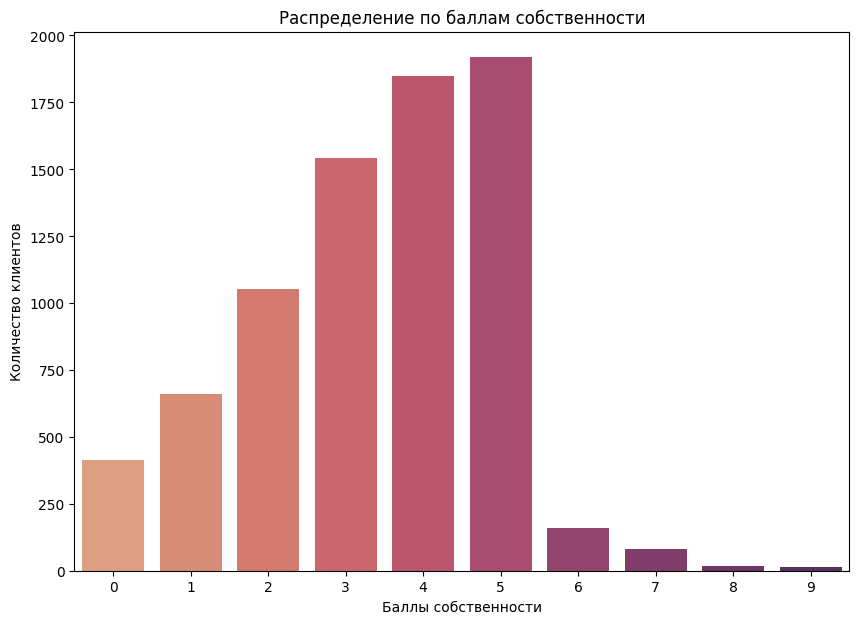

In [70]:
#задаю размер графика
plt.figure(figsize=(10, 7))
plt.title('Распределение по баллам собственности')

sns.barplot(
    x=equity.index, 
    y=equity, 
    data=equity.reset_index(),  
    palette="flare")
plt.ylabel('Количество клиентов')
plt.xlabel('Баллы собственности');

Больше клиентов с 5 баллами собственности, далее по убыванию 4,3,2,1,0,6,7,8,9. 

In [71]:
equity_nan = df_nan['equity'].value_counts()
equity_nan

equity
0    2180
1     114
3       1
Name: count, dtype: int64

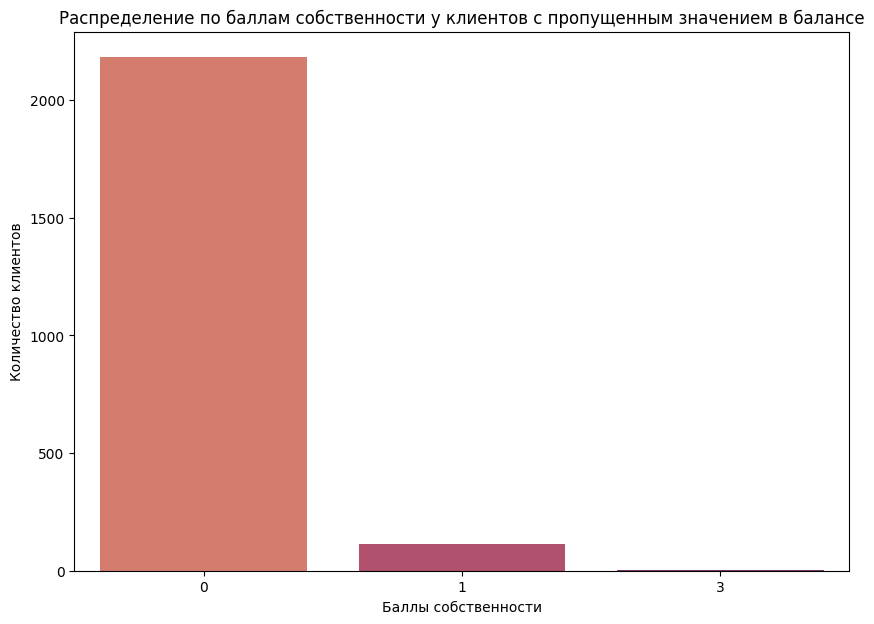

In [72]:
#задаю размер графика
plt.figure(figsize=(10, 7))
plt.title('Распределение по баллам собственности у клиентов с пропущенным значением в балансе')

sns.barplot(
    x=equity_nan.index, 
    y=equity_nan, 
    data=equity_nan.reset_index(),  
    palette="flare")
plt.ylabel('Количество клиентов')
plt.xlabel('Баллы собственности');

Среди климентов с пропущенным значением в балансе наибольшее количество с нулевым баллом собственности, то есть у них нет имущества, которое можно отдать в залог при необходимости. 

## Распределение по количеству продуктов

In [73]:
products = df_balance['products'].value_counts()
products

products
2    4811
1    1391
3    1010
4     474
5      19
Name: count, dtype: int64

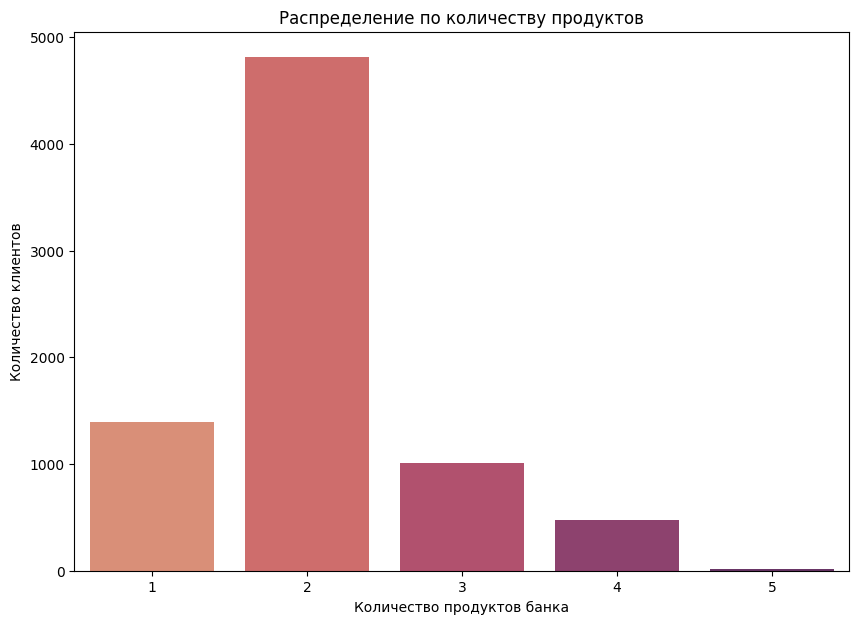

In [74]:
#задаю размер графика
plt.figure(figsize=(10, 7))
plt.title('Распределение по количеству продуктов')

sns.barplot(
    x=products.index, 
    y=products, 
    data=products.reset_index(),  
    palette="flare")
plt.ylabel('Количество клиентов')
plt.xlabel('Количество продуктов банка');

Среди клиентов чаще пользуются двумя продуктами банка. Ноль продуктов банка у клиента быть не может, так как он в таком случае перестает быть клиентом этого банка. 

Необходимо удалить клиента без продуктов, тк он уже не является клиентом банка. 

In [75]:
df2.query('products == 0')
df2 = df2.drop([8957])
df_nan = df_nan.drop([8957])

In [76]:
products_nan = df_nan['products'].value_counts()
products_nan

products
1    1950
2     315
3      29
Name: count, dtype: int64

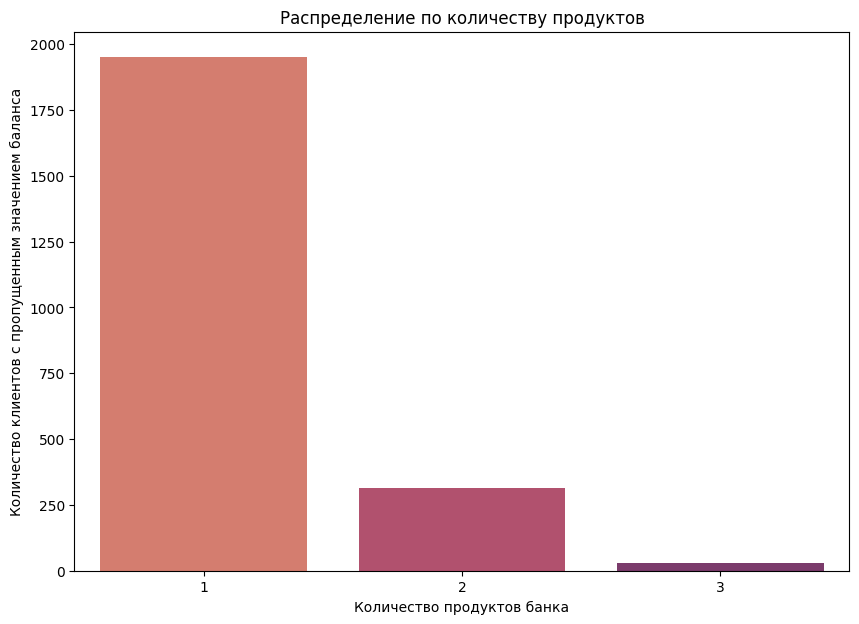

In [77]:
#задаю размер графика
plt.figure(figsize=(10, 7))
plt.title('Распределение по количеству продуктов')

sns.barplot(
    x=products_nan.index, 
    y=products_nan, 
    data=products_nan.reset_index(),  
    palette="flare")
plt.ylabel('Количество клиентов с пропущенным значением баланса')
plt.xlabel('Количество продуктов банка');

У клиентов с пропущенным значением баланса чаще 1 продукт банка. 

## Распределение в зависимости от последней активности

In [78]:
last_activity = df_balance['last_activity'].value_counts()
last_activity

last_activity
1    3974
0    3731
Name: count, dtype: int64

In [79]:
last_activity_nan = df_nan['last_activity'].value_counts()
last_activity_nan

last_activity
1    1261
0    1033
Name: count, dtype: int64

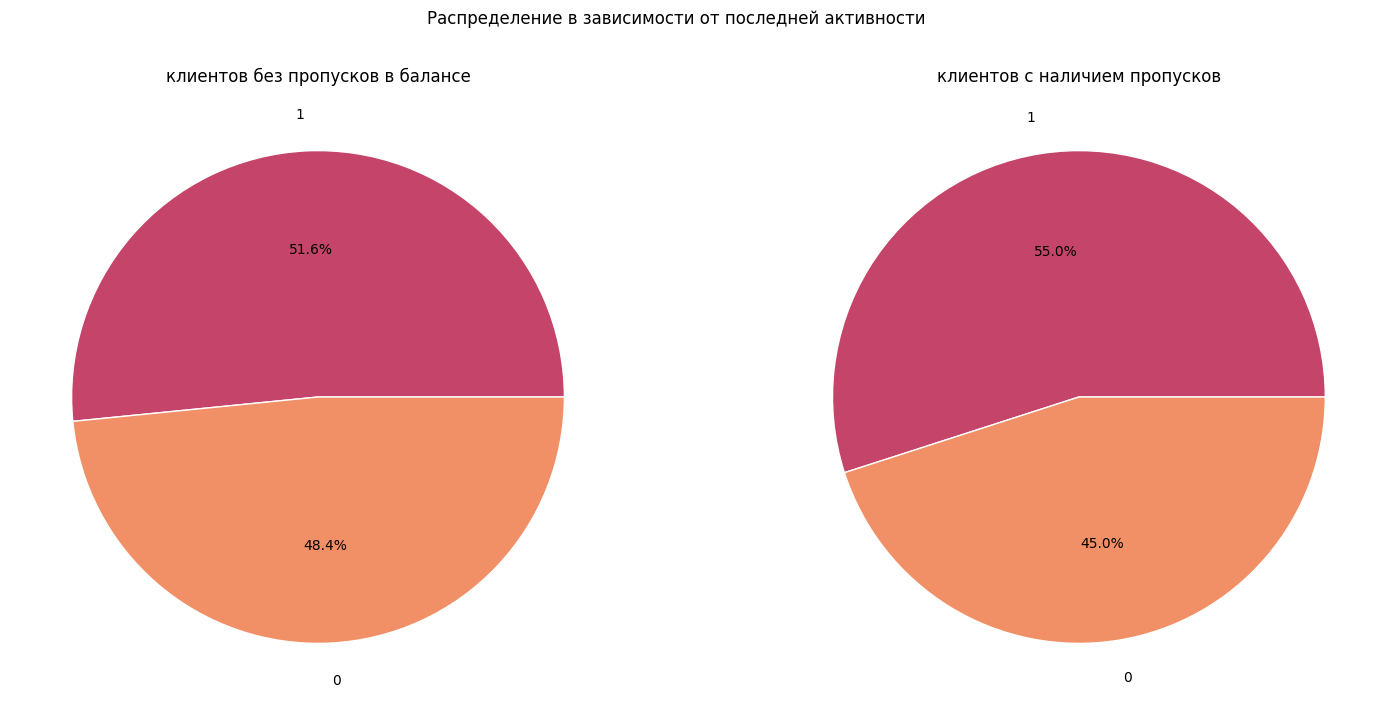

In [80]:
# строю 2 графика           
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8)) 
ax1.pie(last_activity, labels=last_activity.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=['#c44569', '#f19066'])

ax2.pie(last_activity_nan, labels=last_activity_nan.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=['#c44569', '#f19066'])

plt.suptitle('Распределение в зависимости от последней активности')
ax1.set_title('клиентов без пропусков в балансе') # зададим название графика
ax2.set_title('клиентов с наличием пропусков'); # зададим название графика

Среди всех клиентов 51,6% являются активными и 48,4% - неактивны в последние три месяца. У клиентов с пропусками распределение в зависимости от последней активности похожее на остальных клиентов. 

## Распределение в зависимости от наличия кредитной карты

In [81]:
# расчитываю количество клиентов
credit_card = df_balance['credit_card'].value_counts()
credit_card

credit_card
1    4932
0    2773
Name: count, dtype: int64

In [82]:
credit_card_nan = df_nan['credit_card'].value_counts()
credit_card_nan

credit_card
1    1872
0     422
Name: count, dtype: int64

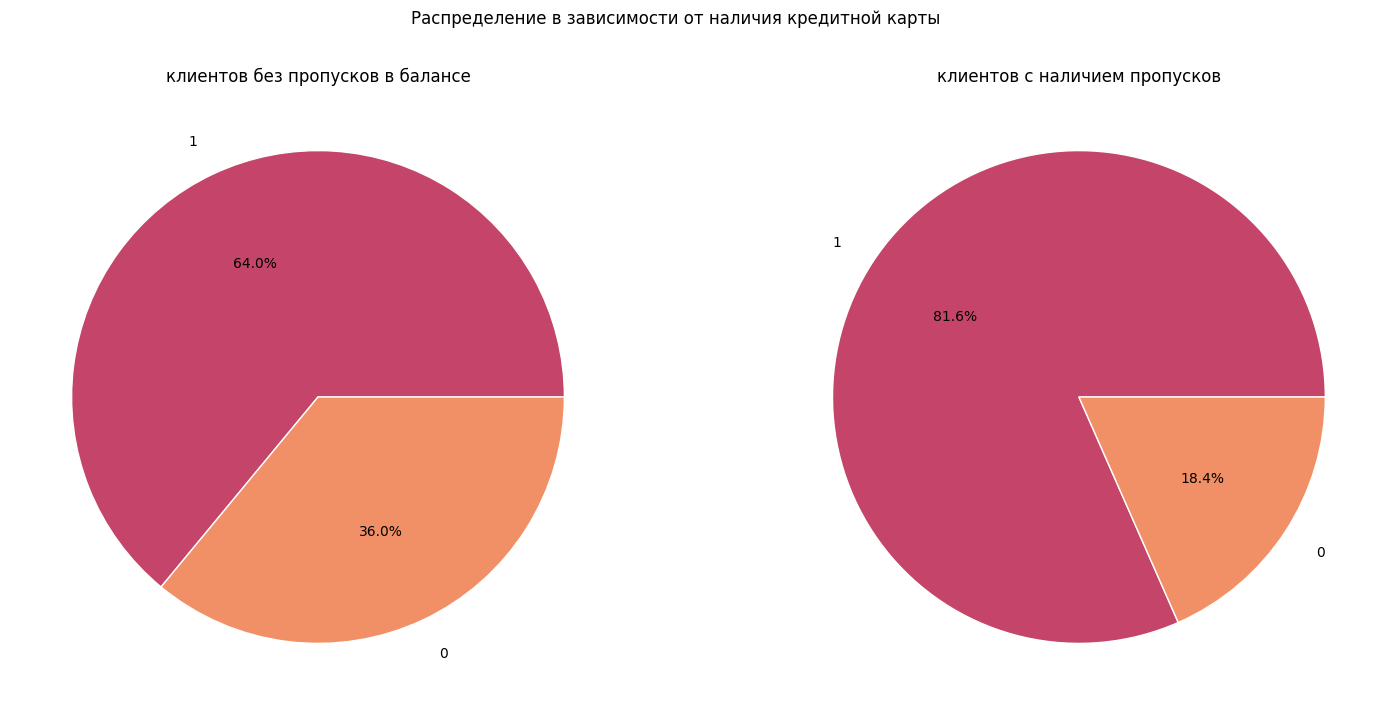

In [83]:
# строю 2 графика           
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8)) 
ax1.pie(credit_card, labels=credit_card.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=['#c44569', '#f19066'])

ax2.pie(credit_card_nan, labels=credit_card_nan.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=['#c44569', '#f19066'])

plt.suptitle('Распределение в зависимости от наличия кредитной карты')
ax1.set_title('клиентов без пропусков в балансе') # зададим название графика
ax2.set_title('клиентов с наличием пропусков'); # зададим название графика

Среди клиентов с пропусками у 82% есть кредитная карта. 

## Подвывод по пропускам

Выходит, что клиента с пропущенным балансом отличает то, что в основном он имеет 0 баллов собственности, чаще пользуется одним продуктом банка и у 82% этим продуктом является кредитная карта. Возможно, у таких клиентов и правда бывает нулевой баланс на карте, когда например происходит списание с кредитного счета задолженности. Буду иметь это в виду, пропуски можно оставить и при необходимости заменять их заглушкой. 

#  Построение матрицы корреляции

Для проведения корреляционного анализа необходимо кодировать данные со строковыми значениями пола и названия города.
Так как в датафрейме присутствуют категориальные данные, интервальные переменные, между которыми может быть нелинейная зависимость, необходимо применять коэфициент Phik (𝜙k) вместо Пирсона, который подходит только для непрерывных данных и определяет лишь линейную зависимость между ними. 

In [84]:
# создаю копии столбцов с названием городов и полом
df2['gender2'] = df2['gender']
df2['city2'] = df2['city']

# применяю метод кодирования столбцов
df2 = pd.get_dummies(df2, columns=['gender2', 'city2'], dtype=int)

df2 = df2.rename(
    columns={
        'gender2_Ж':'women', 'gender2_М':'man', 
        'city2_Ростов' : 'Ростов', 'city2_Рыбинск' : 'Рыбинск', 'city2_Ярославль':'Ярославль'
    })
df2.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,women,man,Ростов,Рыбинск,Ярославль
0,0,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0
1,1,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0
2,2,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,0,1,0
3,3,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1
4,4,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,1,0,0,1


In [85]:
# подготавливаю данные для корреляционного анализа, создаю список столбцов
cols_to_keep = ['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn','women', 'man']
df_corr = df2[cols_to_keep]
df_corr = df_corr.set_index("userid")

In [86]:
# строю таблицу корреляции, округяя значения до 2х знаков после запятой
phik = df_corr.phik_matrix()
phik.round(2)

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'women', 'man']


,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,women,man
score,1.00,0.09,0.07,0.04,0.53,0.17,0.42,0.21,0.05,0.40,0.23,0.07,0.07
city,0.09,1.00,0.01,0.09,0.06,0.04,0.12,0.07,0.03,0.17,0.02,0.01,0.01
gender,0.07,0.01,1.00,0.29,0.06,0.05,0.07,0.20,0.01,0.14,0.22,1.00,1.00
age,0.04,0.09,0.29,1.00,0.04,0.02,0.14,0.16,0.09,0.36,0.18,0.29,0.29
equity,0.53,0.06,0.06,0.04,1.00,0.00,0.58,0.22,0.05,0.29,0.35,0.06,0.06
balance,0.17,0.04,0.05,0.02,0.00,1.00,0.00,0.00,0.00,0.37,0.02,0.05,0.05
products,0.42,0.12,0.07,0.14,0.58,0.00,1.00,0.27,0.11,0.22,0.26,0.07,0.07
credit_card,0.21,0.07,0.20,0.16,0.22,0.00,0.27,1.00,0.05,0.04,0.20,0.20,0.20
last_activity,0.05,0.03,0.01,0.09,0.05,0.00,0.11,0.05,1.00,0.05,0.26,0.01,0.01
est_salary,0.40,0.17,0.14,0.36,0.29,0.37,0.22,0.04,0.05,1.00,0.05,0.14,0.14


In [87]:
# определяю столбцы с интервальными значениями
interval_cols = ['score', 'age', 'equity', 'balance', 'products', 'est_salary']
phik = df_corr.phik_matrix(interval_cols=interval_cols)

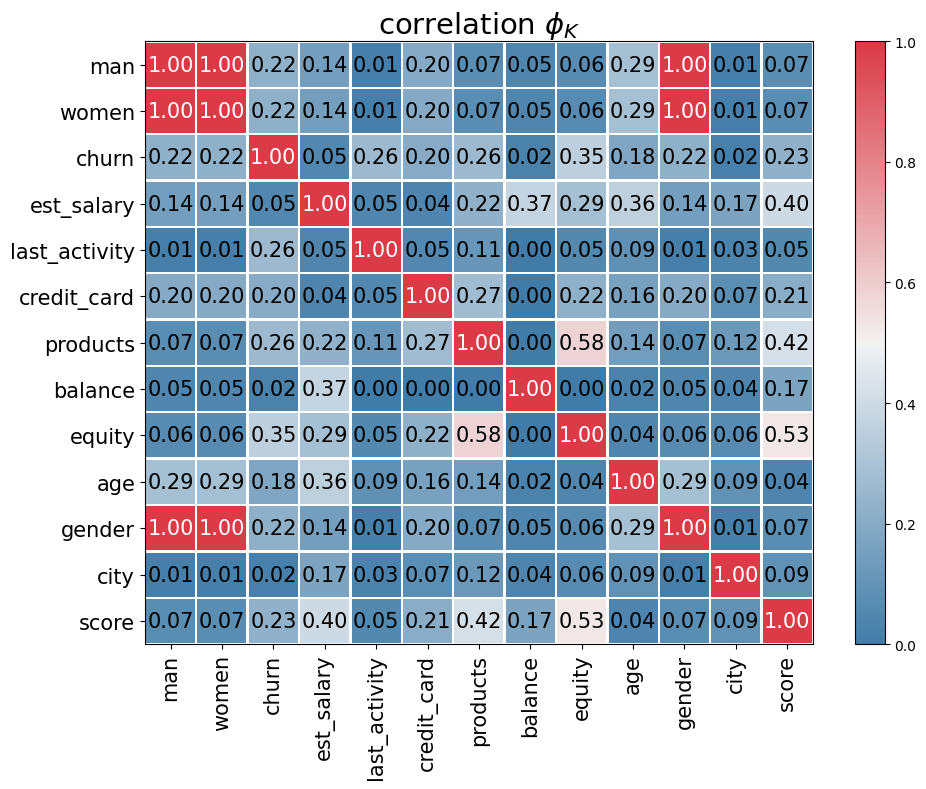

In [88]:
# задаю цветовую палитру и строю матрицу корреляций, применяя тепловую карту
cmap = sns.diverging_palette(600, 10, as_cmap=True)
plot_correlation_matrix(phik.values, 
                        x_labels=phik.columns, 
                        y_labels=phik.index, 
                        vmin=0, vmax=1, color_map=cmap, 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

- Судя по матрице корреляции достаточно сильная зависимость имеется между переменными equity (кол-во баллов собственности) и score, что вполне закономерно, потому что скоринговая система может учитывать наличие у клиента собственности, чтобы подстраховать банк на случай неуплаты долгов.
- Есть корреляция между количеством продуктов и количеством баллов собственности, скоринговым баллом, наличием кредитной карты у клиента, потому что кредитка являются одним из продуктов банка и оттоком.

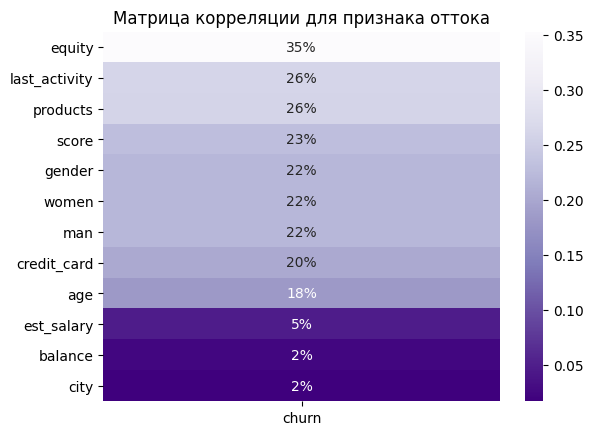

In [89]:
# строю тепловую карту для определения корреляций по признаку оттока клиентов
plt.title('Матрица корреляции для признака оттока')
sns.heatmap(
    phik.loc[:,['churn']].drop('churn')
    .sort_values('churn', ascending=False), 
    annot=True, fmt=".0%",cmap="Purples_r");

Судя по матрице корреляций на признак оттока больше всего влияет количество баллов собственности, чуть меньше - последняя активность клиента и продукты банка, баллы скоринга, пол, наличие кредитной карты и возраст.

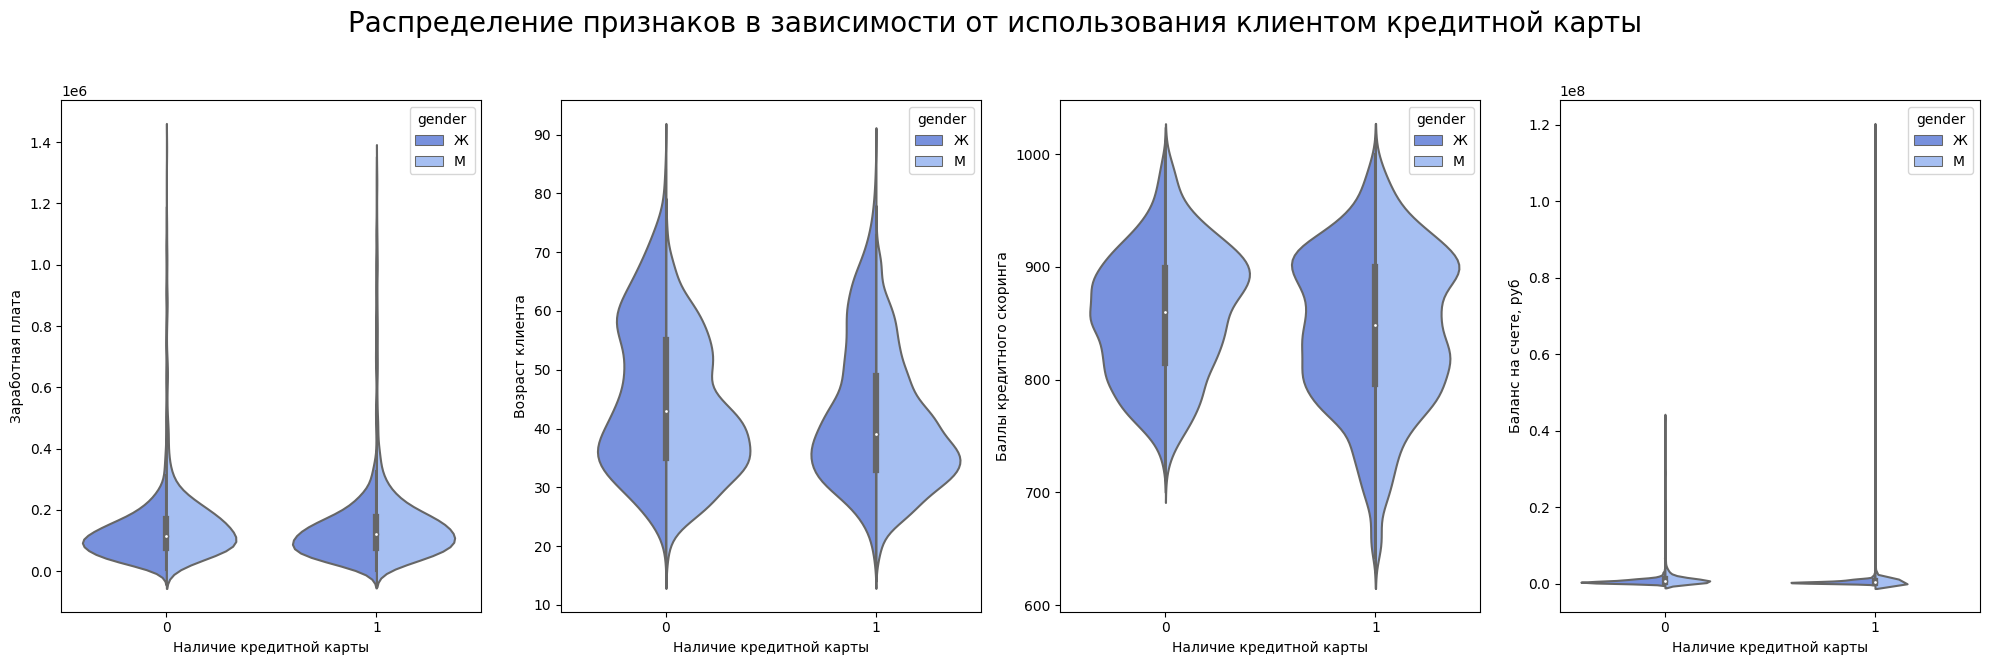

In [116]:
# Напишу функцию для построения violinplot
def subplot(arg, hue, title, xlabel):
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 4)
    
    ax = fig.add_subplot(gs[0, 0])
    sns.violinplot(x=arg, y='est_salary', data=df2, hue=hue, split=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Заработная плата')
    
    ax = fig.add_subplot(gs[0, 1])
    sns.violinplot(x=arg, y='age', data=df2, hue=hue, split=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Возраст клиента')
    
    ax = fig.add_subplot(gs[0, 2])
    sns.violinplot(x=arg, y='score', data=df2, hue=hue, split=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Баллы кредитного скоринга')
    
    ax = fig.add_subplot(gs[0, 3])
    sns.violinplot(x=arg, y='balance', data=df2, hue=hue, split=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Баланс на счете, руб')

    fig.tight_layout()
    fig.suptitle(title, fontsize=20, y=1.1)
    plt.show()
# применю функцию к бинарным признакам    
subplot('credit_card', 'gender', 'Распределение признаков в зависимости от использования клиентом кредитной карты', 'Наличие кредитной карты')    

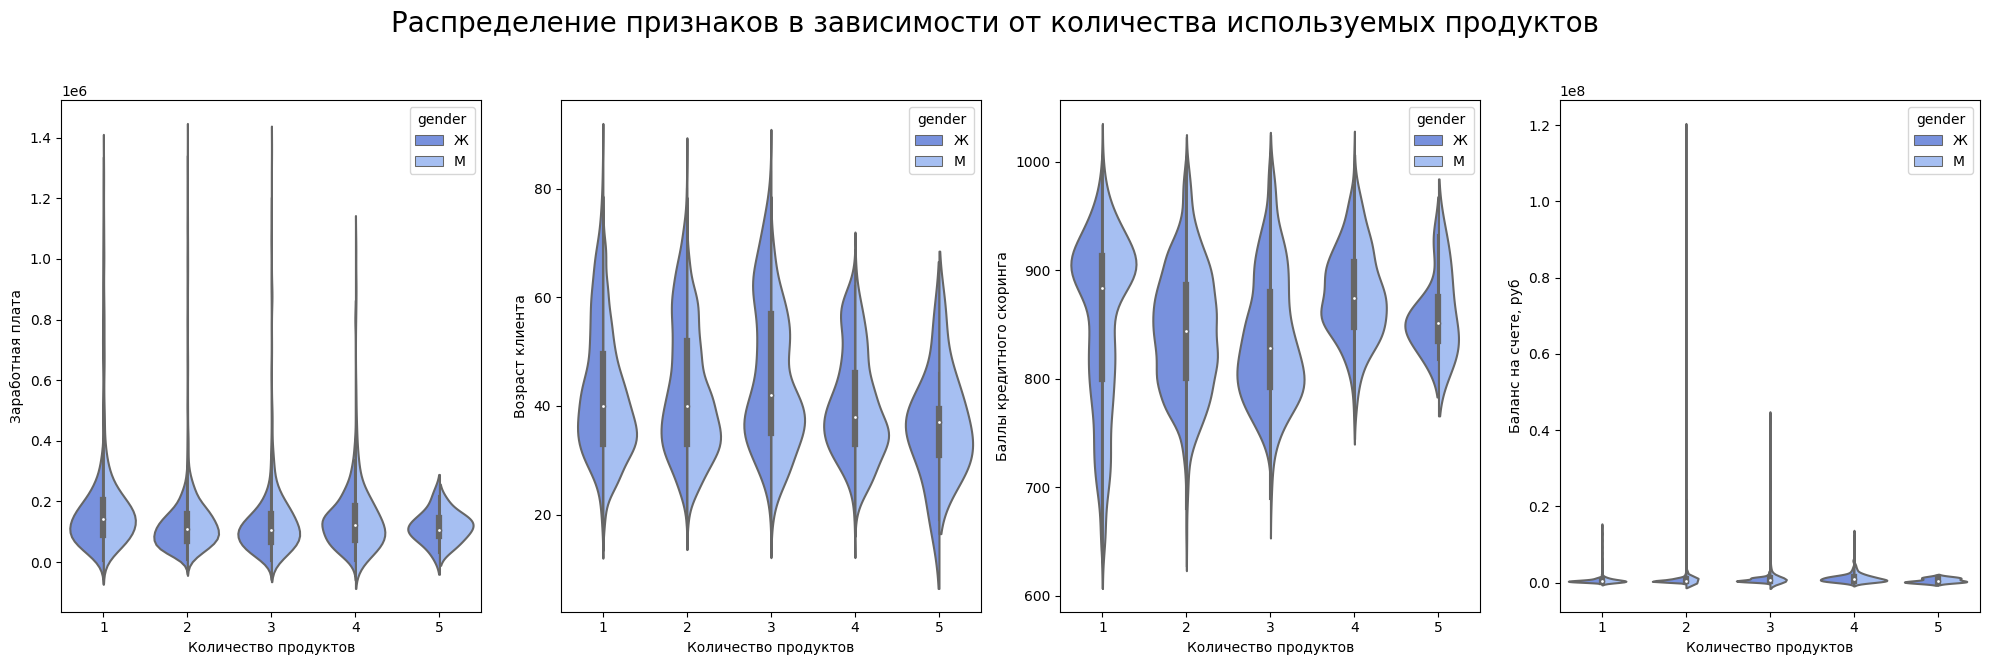

In [117]:
# применю функцию к категориальным признакам 
subplot('products', 'gender', 'Распределение признаков в зависимости от количества используемых продуктов', 'Количество продуктов')    

# Исследование непрерывных данных

Для исследования непрерывных данных используют гистограммы. Для определения отточных сегментов я разделю клиентов на 2 группы по параметру churn и сравню их по различным признакам. Так как наш датасет несбалансирован и размеры групп в нем различны, необходимо использовать нормализованные гистограммы, которые строятся не на основании количества клиентов в различных группах, а на основании плотности веротности определенного события в этой группе. 

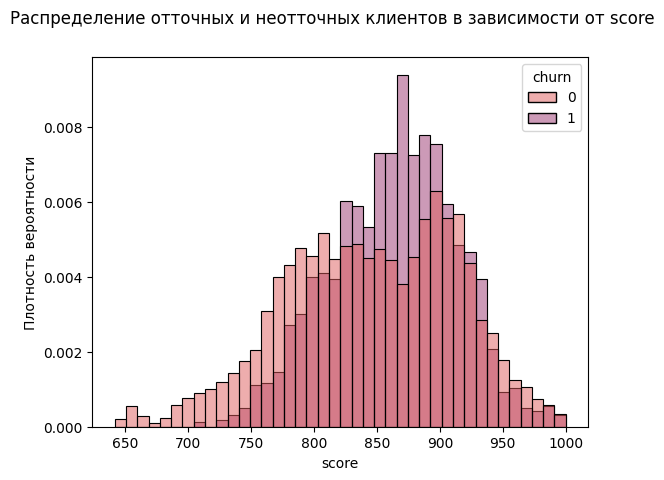

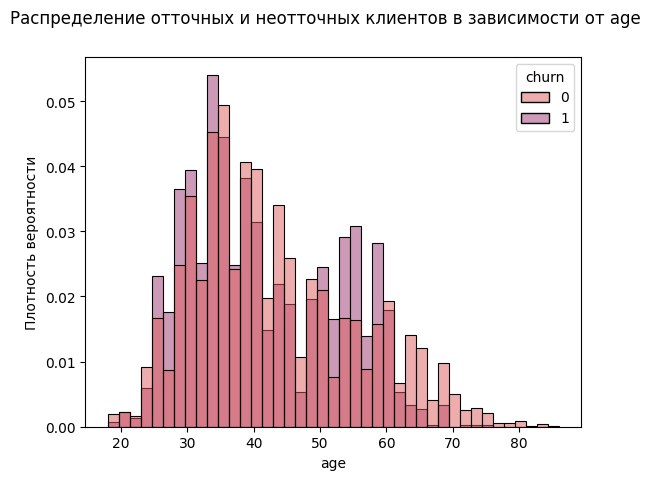

In [54]:
col_name = ['score', 'age']
num = [1,1]
#строю нормализованную гистограмму по непрерывным признакам 
for col,number in zip(col_name,num):
    fig, axes = plt.subplots(number)
    sns.histplot(data=df2, hue="churn", x=col, stat="density", common_norm=False, palette="flare")
    fig.suptitle(f'Распределение отточных и неотточных клиентов в зависимости от {col}') 
    plt.ylabel('Плотность вероятности')
    plt.xlabel(col)
        
plt.show();

Выявляется следующая закономерность: 
- с баллами скоринга от 820 до 970 клиентов отточных больше, чем неотточных, с баллами скоринга менее 820 противоположная картина (распределения неотточных клиентов превышает над отточными). 
- С 25 до 35 лет и в промежуток от 51 до 60 лет клиенты чаще являются отточными. 

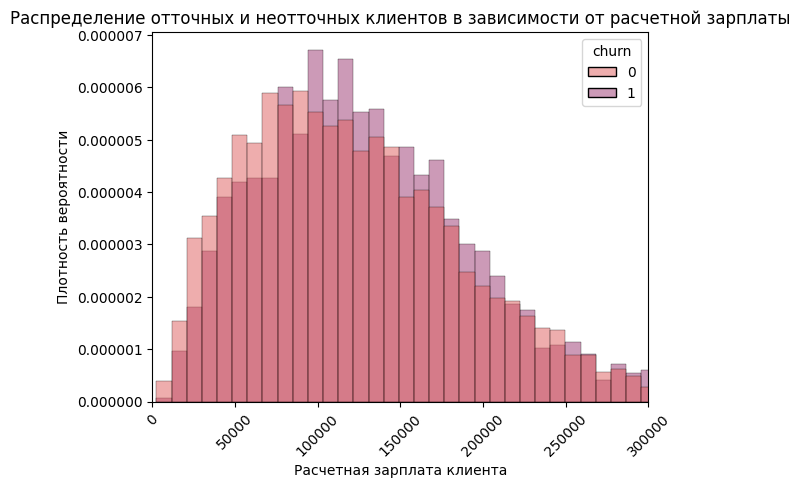

In [55]:
#строю нормализованную гистограмму по признаку est_salary
plt.title('Распределение отточных и неотточных клиентов в зависимости от расчетной зарплаты')
sns.histplot(data=df2, hue='churn', x="est_salary", stat="density", common_norm=False, palette="flare")
plt.ylabel('Плотность вероятности')
plt.xlabel('Расчетная зарплата клиента')

# перевожу значения баланса из scientific notation в привычный формат 
plt.ticklabel_format(style='plain')

# ограничиваю значения по оси х
plt.xlim(0,300000)
plt.xticks(rotation=45);

Судя по диаграмме клиенты с расчетной зарплатой менее более 105000 более подвержены оттоку, а менее 80000 чаще остаются клиентами нашего банка.

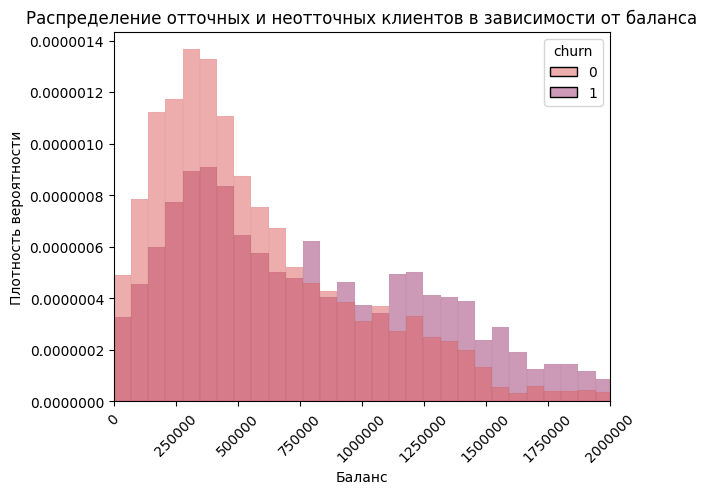

In [56]:
#строю нормализованную гистограмму по признаку balance
plt.title('Распределение отточных и неотточных клиентов в зависимости от баланса')
sns.histplot(data=df2, hue='churn', x="balance", stat="density", common_norm=False, palette="flare")
plt.ylabel('Плотность вероятности')
plt.xlabel('Баланс')

# перевожу значения баланса из scientific notation в привычный формат 
plt.ticklabel_format(style='plain')

# ограничиваю значения по оси х
plt.xlim(0,2000000)
plt.xticks(rotation=45);

Судя по графику выявляется, что люди с балансом более 750000  более подвержены оттоку. 

# Исследование категориальных переменных

Для определения уровня оттока для каждой категории необходимо посчитать относительные показатели оттока для каждого признака по формуле количество отточных клиентов/общий размер категории, потому как абсолютные значения не показательны. 

In [57]:
df2

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,women,man,Ростов,Рыбинск,Ярославль
0,0,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0
1,1,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0
2,2,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,0,1,0
3,3,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1
4,4,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0,0,1,0,1,0
9996,9996,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0,0,1,0,0,1
9997,9997,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0,0,1,0,0,1
9998,9998,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0,1,0,0,0,1


,city,churning,userid
0,Ростов,18.8,1417
1,Рыбинск,16.2,2694
2,Ярославль,19.0,5888


,gender,churning,userid
0,Ж,12.7,4994
1,М,23.6,5005


,products,churning,userid
0,1,7.0,3341
1,2,19.1,5126
2,3,28.6,1039
3,4,63.3,474
4,5,42.1,19


,credit_card,churning,userid
0,0,25.5,3195
1,1,14.7,6804


,last_activity,churning,userid
0,0,11.4,4764
1,1,24.4,5235


,equity,churning,userid
0,0,3.5,2592
1,1,12.0,774
2,2,15.8,1052
3,3,20.8,1542
4,4,25.1,1850
5,5,30.1,1918
6,6,36.0,161
7,7,46.2,80
8,8,35.3,17
9,9,53.8,13


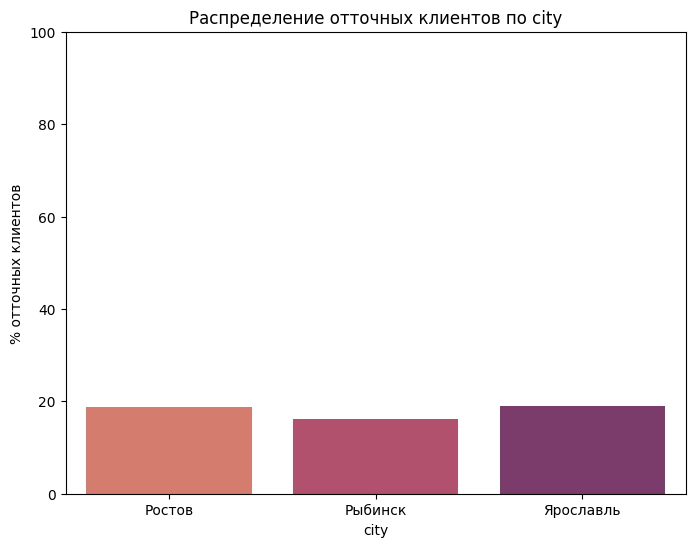

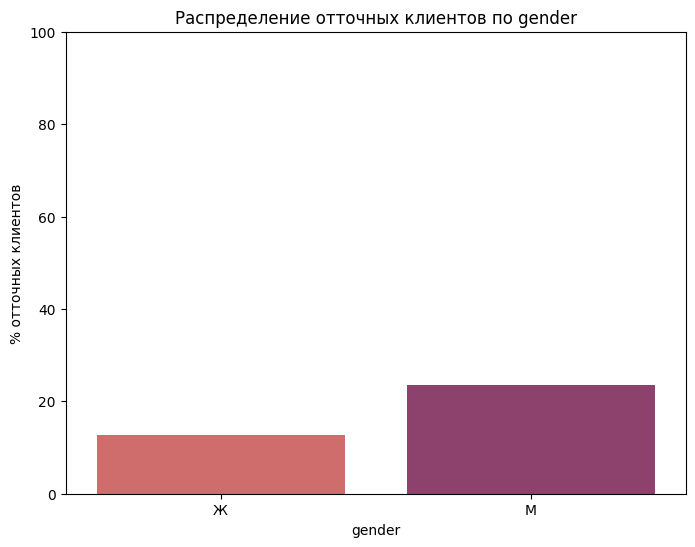

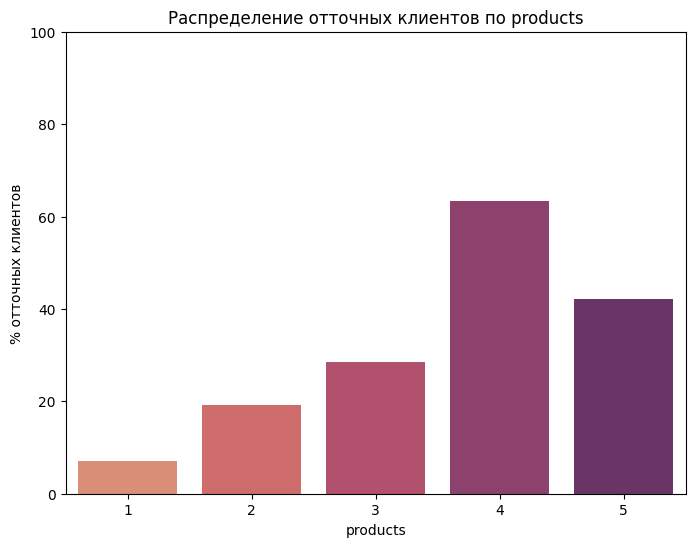

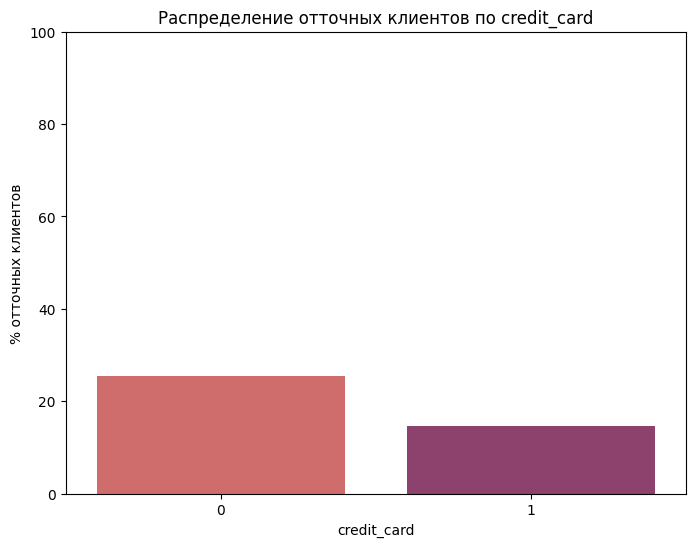

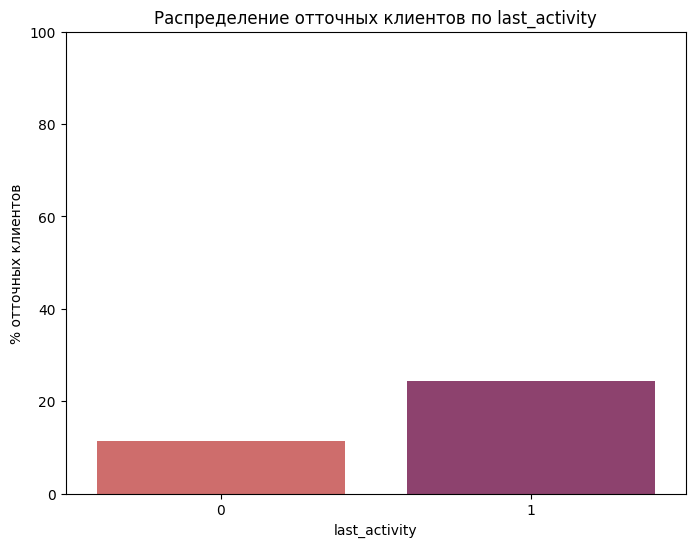

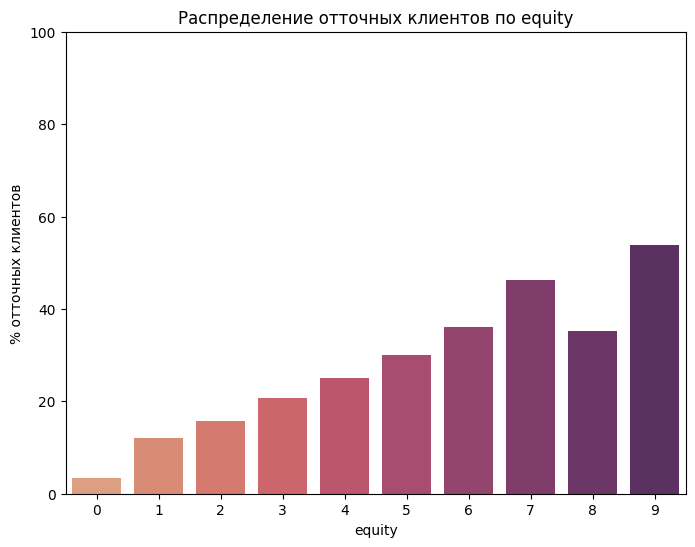

In [58]:
# группирую данные по категориальным признакам с подсчетом уровня оттока и количества клиентов в каждой группе
# строю столбчатые диаграммы по каждой таблице
col_categ = ['city', 'gender', 'products', 'credit_card', 'last_activity', 'equity']
for categ in col_categ:
    df_categ = df2.groupby(categ).agg({'churn':'mean', 'userid':'count'}).reset_index().rename(columns={'churn':'churning'})
    df_categ['churning'] = round(df_categ['churning'] * 100, 1) 
    display(df_categ)
    
    plt.figure(figsize=(8, 6))
    plt.title(f'Распределение отточных клиентов по {categ}')

    sns.barplot(
    x=df_categ[categ], 
    y=df_categ['churning'], 
    data=df_categ.sort_values('churning'),  
    palette="flare")
    plt.ylabel('% отточных клиентов')
    plt.xlabel(categ)
    plt.ylim(0,100);

- Примерно одинаковое отношение отточных клиентов по всем городам: в районе 18% в Ростове и Ярославле и 16% в Рыбинске.
- Судя по полу, мужчины чаще перестают быть клиентами банка, чем женщины (на 10 проц. пунктов).
- Клиенты без кредитки являются более отточными (на 10 проц. пунктов).
- Уровень оттока среди активных клиентов превышает неактивных на 10 проц. пунктов.
- В зависимости от баллов собственности отмечается достаточно явная закономерность: при увеличении баллов увеличивается и уровень оттока клиентов. 

Максимальный уровень оттока выявлен у клиентов с 4мя продуктами и составляет 63.3 %, что достаточно странно. Клиенты с 1 продуктом чаще продолжают сотрудничать с банком, что хорошо. 
Можно сегментировать клиентов по количеству используемых продуктов банка:
- 1 сегмент с 1 продуктом, которым чаще является кредитная карта, состоит из 3341 клиентов, уровень оттока которых 7%. 
- 2 сегмент с 2 продуктами состоит из 5126 клиентов, уровень оттока которых равен 19%. 
- 3 сегмент с 3 продуктами состоит из 1039 клиентов, уровень оттока которых равен 28.6%. 
- 4 сегмент с 4 продуктами состоит из 474 клиентов, уровень оттока которых максимальный и составляет 63.3%.
- 5 сегмент с 5 продуктами самый малочисленный, состоит из 19 клиентов, уровень оттока которых максимальный также высокий 42%.

## Подвывод по уровню оттока

Отток зависит от (по убыванию уровня корреляции):
- баллов собственности (чем выше балл, тем выше уровень оттока) 
- активности клиента:  более активные клиенты в два раза больше подвержены оттоку, чем неактивные.
- от количества используемых продуктов банка (63.3 % оттока среди клиентов с 4 продуктами банка, что достаточно странно. Клиенты с 1 продуктом чаще продолжают сотрудничать с банком, что хорошо)
- баллов скоринга (с баллами скоринга от 820 до 970 неотточных клиентов больше)
- мужчины чуть более подвержены оттоку, чем женщины
- наличия кредитной карты: клиенты без кредитки более подвержены оттоку
- возраста (С 25 до 35 лет и с 51 до 60 лет клиенты более подвержены оттоку)
- расчетной зп (более 105000 более отточны)
- баланса на карте (более 750000  более подвержены оттоку)


Выходит, что оттоку подвержены более благонадежные клиенты с высоким уровнем дохода и большим количеством собственности, пользующиеся максимальным количеством продуктов и предложений от банка! 

# Сегментация 

Для сегментации пользователей необходимо объединять их по различным признакам и считать средий уровень оттока в каждой группе, он должен превышать средний уровень оттока по всем пользователям хотя бы в два раза, который составляет 18%. 

## Портрет клиента в зависимости от количества используемых продуктов

Выше я разделила клиентов на 5 сегментов:
- 1 сегмент с 1 продуктом, которым чаще является кредитная карта, состоит из 3341 клиентов, уровень оттока которых 7%. 
- 2 сегмент с 2 продуктами состоит из 5126 клиентов, уровень оттока которых равен 19%. 
- 3 сегмент с 3 продуктами состоит из 1039 клиентов, уровень оттока которых равен 28.6%. 
- 4 сегмент с 4 продуктами состоит из 474 клиентов, уровень оттока которых максимальный и составляет 63.3%.
- 5 сегмент с 5 продуктами самый малочисленный, состоит из 19 клиентов, уровень оттока которых максимальный также высокий 42%.

По количеству продуктов в разрезе городов

In [83]:
segman = df2.pivot_table(index='products', values='userid', columns='city', aggfunc='count', margins=True)
segman.reset_index()
segman['part_of_all'] = (segman['All'] / len(df2) * 100).round(1)
segman

city,Ростов,Рыбинск,Ярославль,All,part_of_all
products,,,,,
1,444,865,2032,3341,33.4
2,806,1563,2757,5126,51.3
3,95,166,778,1039,10.4
4,68,99,307,474,4.7
5,4,1,14,19,0.2
All,1417,2694,5888,9999,100.0


In [62]:
for i in df2['products'].unique():
    display(f'Клиенты, пользующиеся {i} продуктами', df2[(df2['products'] == i)]
            .drop(['userid', 'products', 'city', 'gender'], axis=1).groupby('churn').mean())

'Клиенты, пользующиеся 2 продуктами'

,score,age,equity,balance,credit_card,last_activity,est_salary,women,man,Ростов,Рыбинск,Ярославль
churn,,,,,,,,,,,,
0,839.926694,43.227723,3.009887,7.296138e+05,0.664336,0.461538,126885.150113,0.563540,0.436460,0.157463,0.309380,0.533156
1,864.206333,40.826176,3.749745,1.140471e+06,0.460674,0.747702,145264.380582,0.350358,0.649642,0.156282,0.286006,0.557712


'Клиенты, пользующиеся 3 продуктами'

,score,age,equity,balance,credit_card,last_activity,est_salary,women,man,Ростов,Рыбинск,Ярославль
churn,,,,,,,,,,,,
0,832.218329,46.337382,3.366577,9.386734e+05,0.369272,0.346361,124035.063841,0.628032,0.371968,0.091644,0.176550,0.731806
1,850.023569,44.161616,3.898990,1.128787e+06,0.323232,0.592593,140196.894545,0.424242,0.575758,0.090909,0.117845,0.791246


'Клиенты, пользующиеся 1 продуктами'

,score,age,equity,balance,credit_card,last_activity,est_salary,women,man,Ростов,Рыбинск,Ярославль
churn,,,,,,,,,,,,
0,854.609466,42.249028,1.189311,601133.031151,0.860914,0.518352,183899.794688,0.473278,0.526722,0.127173,0.260464,0.612363
1,850.182979,41.502128,3.114894,660515.440485,0.902128,0.659574,138849.512298,0.272340,0.727660,0.208511,0.238298,0.553191


'Клиенты, пользующиеся 4 продуктами'

,score,age,equity,balance,credit_card,last_activity,est_salary,women,man,Ростов,Рыбинск,Ярославль
churn,,,,,,,,,,,,
0,869.505747,38.114943,4.126437,9.120333e+05,0.500000,0.948276,105456.282241,0.454023,0.545977,0.178161,0.201149,0.620690
1,883.350000,40.750000,4.166667,1.474177e+06,0.786667,0.696667,173921.901833,0.333333,0.666667,0.123333,0.213333,0.663333


'Клиенты, пользующиеся 5 продуктами'

,score,age,equity,balance,credit_card,last_activity,est_salary,women,man,Ростов,Рыбинск,Ярославль
churn,,,,,,,,,,,,
0,837.363636,36.000,3.090909,1.742656e+05,1.0,1.00,99789.689091,0.545455,0.454545,0.363636,0.000,0.636364
1,889.375000,37.125,4.500000,1.211478e+06,1.0,0.75,139837.798750,0.375000,0.625000,0.000000,0.125,0.875000


Портрет отточных клиентов, использующих 1 продукт банка:
- мужчина 41,5 лет со средним баллом скоринга 850, 3 баллами за наличие собственности, в 90% у него есть кредитка, средняя расчетная зп 138849 и баланс на карте 660515

Портрет отточных клиентов, использующих 2 продукта банка:
- чаще мужчины 40 лет со средним баллом скоринга 864, 3,7 баллами за наличие собственности, в 46% у него есть кредитка, средняя расчетная зп 145264 и баланс на карте 1млн 114

Портрет отточных клиентов, использующих 3 продукта банка:
- чаще мужчины 44 лет со средним баллом скоринга 850, 3,9 баллами за наличие собственности, в 32% у него есть кредитка, средняя расчетная зп 140196 и баланс на карте более 1 млн 128

Портрет отточных клиентов, использующих 4 продукта банка:
- чаще мужчины 40 лет со средним баллом скоринга 883, 4 баллами за наличие собственности, в 78% у него есть кредитка, средняя расчетная зп 173921 и баланс на карте более 1 млн 474

Портрет отточных клиентов, использующих 4 продукта банка:
- чаще мужчины 37 лет со средним баллом скоринга 889, 4.5 баллами за наличие собственности, у него есть кредитка, средняя расчетная зп 139837 и баланс на карте более 1 млн 211

## Сегментация по возрасту

In [63]:
age = ['young', 'middle', 'old', 'elderly']
cut_bins = [17, 35, 50, 60, 90]

df2['age_categ'] = pd.cut(df2['age'],
                       bins=cut_bins,
                       labels=age)

Разделю на сегменты в зависимости от возраста клиента, с учетом того, что оттоку больше подвержены клиенты в возрасте 25-35 лет и 51-60 лет. 
- Категория молодые от 18 до 35 лет
- Категория средний возраст от 36 до 50 лет
- Категория зрелого возраста от 51 до 60 лет
- Категория пенсионеры старше 60 лет

In [65]:
# группирую по городам и считаю среднее значение отточных клиентов в зависимости от количества продуктов
df_ages = (df2.groupby('age_categ')
               .agg({'churn':'mean', 'userid':'count'}).reset_index().sort_values('churn'))
df_ages['churn'] =round(df_ages['churn']* 100,2)
df_ages

,age_categ,churn,userid
3,elderly,6.40,1032
1,middle,15.32,4072
0,young,21.15,3291
2,old,27.38,1578


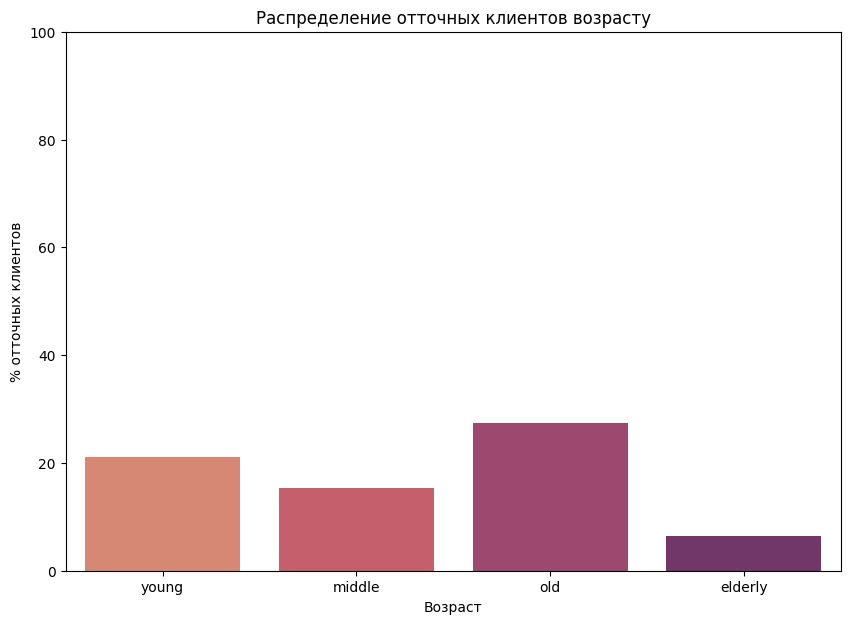

In [66]:
# задаю размер графика
plt.figure(figsize=(10, 7))
plt.title('Распределение отточных клиентов возрасту')

sns.barplot(
    x='age_categ', 
    y='churn', 
    data=df_ages,  
    palette="flare")
plt.ylabel('% отточных клиентов')
plt.xlabel('Возраст')
plt.ylim(0, 100);

Оттоку больше подвержены люди зрелого и молодого возраста.

## Сегментация по количеству используемых продуктов

Судя по вышепостроенным графикам можно выделить следующие срезы, которые более подвержены оттоку:
- ('products  >=  4')
- ('gender == "М"')
- ('age_categ == "old"')
- ('balance > 750000')
- ('score >= 820 & score <= 970')
- ('est_salary > 105000')
- ('last_activity == 1')

При их комбинировании будем получать наиболее отточные сегменты клиентов. 

In [67]:
df2.query('products >= 4 & gender == "М"').agg({'churn':['mean', 'count']})

,churn
mean,0.672131
count,305.000000


In [68]:
df2.query('products >= 4 & age_categ == "old"').agg({'churn':['mean', 'count']})

,churn
mean,0.701299
count,77.000000


In [69]:
df2.query('products >= 4 & balance > 750000').agg({'churn':['mean', 'count']})

,churn
mean,0.788321
count,274.000000


In [70]:
df2.query('products >= 4 & score >= 820 & score <= 970').agg({'churn':['mean', 'count']})

,churn
mean,0.610503
count,457.000000


In [71]:
df2.query('products >= 4 & est_salary > 105000').agg({'churn':['mean', 'count']})

,churn
mean,0.774744
count,293.000000


In [72]:
df2.query('products >= 4 & last_activity == 1').agg({'churn':['mean', 'count']})

,churn
mean,0.549872
count,391.000000


Учитывая признак использования более 4х продуктов банка и остальные признаки выявляются наиболее отточные сегменты:
- мужчины: из 305 клиентов 67% отточных  
- клиенты с балансом более 750000: среди 274 клиентов 78.8% отточных
- клиенты зрелого возраста: среди 77 клиентов 70% отточных
- с баллами скоринга от 820 до 970: среди 457 клиентов 61% отточных
- с расчитанной зарплатой более 105000: среди 293 клиентов более 77% отточных
- активнные клиенты: среди 391 клиента 55% отточных

## Сегментация по уровню баланса

In [73]:
df2.query('balance > 750000 & score >= 820 & score <= 970 & credit_card == 0').agg({'churn':['mean', 'count']})

,churn
mean,0.485656
count,976.000000


In [74]:
df2.query('balance > 750000 & age_categ == "old" ').agg({'churn':['mean', 'count']})

,churn
mean,0.455856
count,555.000000


In [75]:
df2.query('balance > 750000 & est_salary > 105000 & credit_card == 0').agg({'churn':['mean', 'count']})

,churn
mean,0.481258
count,827.000000


In [76]:
df2.query('balance > 750000 & last_activity == 1 & credit_card == 0').agg({'churn':['mean', 'count']})

,churn
mean,0.569069
count,666.000000


Учитывая баланс на счету у клиента  выше 750000 и остальные признаки выявляются более отточные сегменты:
- среди 555 зрелых клиентов 45.5% являются отточными
- с баллом скоринга от 820 до 970 среди 2064 клиентов 40% отточных
- с расчитанной зп выше 105000 среди 1807 клиентов 40.5% отточных
- среди активных клиентов из 1419 48% являются отточными

Таким образом, выделяю следующие <b> категории наболее отточных клиентов: </b>
- мужчины с более чем 4 продуктами (67% оттока, 305 клиентов) 
- с балансом более 750000, баллами скоринга от 820 до 970 и без кредитной карты (48% оттока, 976 клиентов)
- с более 4 продуктами банка и зрелого возраста (70%, 77 клиентов)
- активные клиенты с более чем 4 продуктами (55% оттока, 391 клиент)

# Статистические гипотезы

## Гипотеза о различие в средних показателях между двумя независимыми группами

Необходимо сравнить равенство двух средних генеральных совокупностей с помощью t-теста Стьюденса, потому что наши группы не пересекаются и выборки по возрасту не содержат выбросов. Будем считать, что дисперсии наших выборок разные и использовать equal_var = False. Также применим параметр nan_policy='omit', который не будет учитывать пропущенные значения в категории возраст. 

Формулирую гипотезы:

- Н0: средний возраст клиентов, использующих один продукт банка и два, значимо не различается.
- Н1: есть различие в среднем возрасте клиентов, использующих один продукт банка и теми, кто пользуется двумя.    

In [77]:
# Сформирую массив данных по колонке age
prod_1 = df2.query('products == 1')['age']
prod_2 = df2.query('products == 2')['age']
print('Количество пользователей в группе 1:', df2.query('products == 1')['userid'].count())
print('Средний возраст в 1 группе',df2.query('products == 1')['age'].mean())
print('Количество пользователей в группе 2:', df2.query('products == 2')['userid'].count())
print('Средний возраст во 2 группе',df2.query('products == 2')['age'].mean())

Количество пользователей в группе 1: 3341
Средний возраст в 1 группе 42.19620824556124
Количество пользователей в группе 2: 5126
Средний возраст во 2 группе 42.76890017581559


In [79]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(prod_1, prod_2, nan_policy='omit', equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.03299080704232691
Отвергаем нулевую гипотезу


В результате стат теста p-value оказался чуть меньше заданного уровня стат значимости, следовательно, мы отвергаем нулевую гипотезу о равенстве среднего, средний возраст в группе, использующей 1 продукт банка (42,2) и группе, использующей 2 продукта банка (42,8) значимо различны. 

## Гипотеза о различии долей в двух группах

Проверю гипотезу о равенстве долей двух групп, используя z-test.
Гипотезы:
- Н0 - доля оттока среди мужчин и женщин равна
- Н1 - доли оттока среди мужчин и женщин различны

In [80]:
for g in df2['gender'].unique(): 
    print('Количество отточных:', df2[(df2['gender'] == g)]['churn'].sum())
    print('Всего:', df2[(df2['gender'] == g)]['churn'].count())
    print('Уровень оттока:', df2[(df2['gender'] == g)]['churn'].sum() / df2[(df2['gender'] == g)]['churn'].count())

Количество отточных: 636
Всего: 4994
Уровень оттока: 0.12735282338806567
Количество отточных: 1183
Всего: 5005
Уровень оттока: 0.23636363636363636


In [82]:
successes = [df2.query('gender == "М"')['churn'].sum(), df2.query('gender == "Ж"')['churn'].sum()]
trials = [df2.query('gender == "М"')['churn'].count(), df2.query('gender == "Ж"')['churn'].count()]

value = .05 # критический уровень статистической значимости
stat, pval = proportions_ztest(successes, trials, value)

print('p-значение: ','{0:0.3f}'.format(pval))

if pval < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.000
Отвергаем нулевую гипотезу: между долями есть значимая разница


Уровень оттока среди мужчин (0,23) и женщин (0,12) значимо различаются. 

# Выводы

Во время анализа среза данных банка были обнаружены большое количество пропущенных значений 23% в столбце с балансом, также немного в столбце с возрастом, пропуски ничем не замещались. Было выявлено, что клиента с пропущенным балансом отличает то, что в основном он имеет 0 баллов собственности, чаще пользуется одним продуктом банка и у 82% этим продуктом является кредитная карта. Возможно, у таких клиентов бывает нулевой баланс на карте и пропущенные значения это нули. 

При построение матрицы корреляции мною были определенны признаки, наиболее сильно влияющие на отток клиентов: количество баллов собственности, чуть меньше - последняя активность клиента и продукты банка, баллы скоринга, пол, наличие кредитной карты и возраст.

При более подробном изучении оттока в разрезе различных категориальных, непрерывных признаков были выявлены срезы наиболее отточных клиентов, по которым в дальнейшем я формировала сегменты отточных пользователей, их получилось 10. При последующей приоритезации сегментов и комбинировании признаков я выделила 4 наиболее отточных сегмента, состоящих из 300-900 клиентов.
Отточными клиентами являются обеспеченные и благонадежные клиенты с высоким доходом, баллом скоринга, чаще мужчины молодого или зрелого возраста, пользующиеся большим количеством продуктов банка.  
Стоит задуматься о том, что с увеличением количества используемых продуктов растет отток клиентов, посмотреть, всегда ли так было, оценить в динамике. Такая тенденция не совсем логичная, клиент пользуется многими продуктами банка, но при этом уходит в другие банки, вероятно его перестали устраивать предложения данного банка либо банк конкурент предложил более выгодные пакеты. 

<b>1 сегмент: </b> мужчины с более чем 4 продуктами банка (67% оттока, 305 клиентов) из Ярославля, активно пользующиеся услугами банка, большинство из них имеют кредитную карту. Данному сегменту можно предложить выгодные вклады с повышенным процентом или выгодные ипотечные программы. 

<b>2 сегмент: </b>обеспеченные клиенты с балансом более 750000, и высокими баллами скоринга от 820 до 970, без кредитной карты (48% оттока, 976 клиентов). Данному сегменту также подойдут вклады с высоким процентом, чтобы деньги на балансе приносили ежемесячный доход. 

<b>3 сегмент: </b>клиенты зрелого возраста, активно пользующиеся более чем 4 продуктами банка (70%, 77 клиентов) - сегмент немногочисленный, но с высоким уровнем оттока. Данному сегменту в силу возраста, близкого к пенсионному, можно предложить выгодную пенсионную программу.

<b>4 сегмент: </b>активные клиенты с более чем 4 продуктами банка более молодого возраста (55% оттока, 391 клиент) - активным молодым клиентам стоит предложить выгодные инвестиционные пакеты, молодые люди заинтересованы в приумножении своих доходов и не боятся рисковать, что должно помочь снизить их уровень оттока.  